# Beginner's Tutorial for VisCube

In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
from viscube import grid_cube_all_stats, save_gridded_npz, load_and_mask, hermitian_augment
import numpy as np

In [17]:
path = "/home/darthbarth/Data/ngc_4697/NGC4697_visibilities.npz"
data = np.load(path)
freq = data["frequencies"]
u_raw = data["uu"]
v_raw = data["vv"]
vis_raw = data["data"]
weight_raw = data["weight"]
mask = data["mask"]

In [18]:
frequencies, u0, v0, vis0, weight0 = load_and_mask(freq, u_raw, v_raw, vis_raw, weight_raw, mask)

In [19]:
uu, vv, vis_re, vis_imag, wt = hermitian_augment(u0, v0, vis0, weight0)

In [20]:
mean_re, mean_im, std_re, std_im, counts, u_edges, v_edges = grid_cube_all_stats(
    frequencies=freq, uu=uu, vv=vv, vis_re=vis_re, vis_imag=vis_imag, weight=wt,
    npix = 501, window_name="kaiser_bessel",
    window_kwargs={"m": 6},   # only KB will use beta; m/normalize optional
)

100%|██████████| 83/83 [02:48<00:00,  2.03s/channel, coarse_std_im=332, coarse_std_re=332]


In [23]:
from supermage.utils.cube_tools import dirty_cube_tool, velocity_map, create_velocity_grid_stable
fov_arcseconds = 206265*501/(2*461206.80374266725)
num_pixels_uv = 501
arcseconds_per_pixel = fov_arcseconds / num_pixels_uv
freq_path = "/home/darthbarth/Data/ngc_4697/frequencies_correct.npy"
max_freq_index = 74
freq = (np.load(freq_path)/1e9)[:max_freq_index]
systemic_velocity = 1239.9591200072425
velocities_absolute, _ = create_velocity_grid_stable(freq[0], freq[-1], len(freq))
velocities = velocities_absolute.numpy() - systemic_velocity

# Define the region of interest for the cube (pixels 1000 to 1050)
roi_start, roi_end = 225, 276
fov_pixels = roi_end - roi_start
dirty_cube = dirty_cube_tool(mean_re, mean_im, roi_start, roi_end)
extent = (-1*arcseconds_per_pixel*fov_pixels/2, arcseconds_per_pixel*fov_pixels/2, -1*arcseconds_per_pixel*fov_pixels/2, arcseconds_per_pixel*fov_pixels/2)

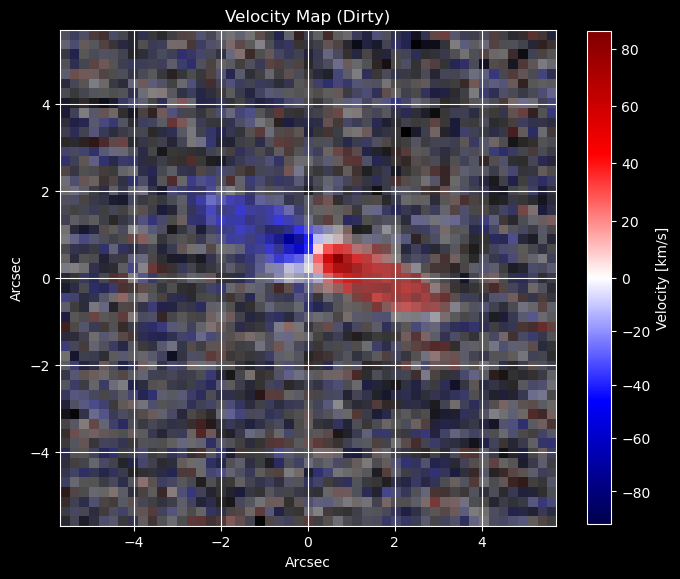

In [24]:
vel_map = velocity_map(dirty_cube[:, :, :max_freq_index], velocities)
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc, colors

plt.style.use('dark_background')
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.set_aspect('equal', adjustable='box')

divnorm=colors.TwoSlopeNorm(vcenter=0.)
im11 = ax1.imshow(vel_map, cmap = "seismic", norm = divnorm, origin = "lower",  extent=extent)
c_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0)
c_black= matplotlib.colors.colorConverter.to_rgba('black',alpha = 1)
cmap_rb = matplotlib.colors.LinearSegmentedColormap.from_list('rb_cmap',[c_black, c_white],256)
im12 = ax1.imshow(np.sum(dirty_cube[:, :, :max_freq_index], axis = 2), cmap = cmap_rb, origin = "lower",  extent=extent)

fig.colorbar(im11, label = "Velocity [km/s]", shrink = 0.8)
ax1.set_xlabel("Arcsec")
ax1.set_ylabel("Arcsec")
ax1.set_title("Velocity Map (Dirty)")
plt.grid()
plt.show()

In [25]:
save_dir1 = "/home/darthbarth/Data/ngc_4697/NGC4697_kaiser_bessel/gridded_visibilities_viscube.npz"
save_gridded_npz(
    save_dir1,
    mean_re,
    mean_im,
    std_re,
    std_im,
    counts,
)